<a href="https://colab.research.google.com/github/Wassefy/Sentences_Emotion_Recognition/blob/main/Sentences_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install pyvi

     |████████████████████████████████| 8.5 MB 3.8 MB/s 
     |████████████████████████████████| 743 kB 62.4 MB/s 


In [3]:
import os
import re
import codecs
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from pyvi import ViTokenizer
from pyvi import ViUtils
from __future__ import print_function
from spacy.lang.vi import Vietnamese
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [4]:
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER

In [5]:
# Xóa dấu câu
def no_marks(s):
  __INTAB = [ch for ch in VN_CHARS]
  __OUTAB =  "a"*17 + "0"*17 + "e"*11 + "u"*11 + "i"*5 +  "y"*5 + "d"*2
  __OUTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 +  "Y"*5 + "D"*2
  __r = re.compile('|'.join(__INTAB))
  __replaces_dict = dict(zip(__INTAB, __OUTAB))
  result = __r.sub(lambda m: __replaces_dict[m.group(0)], s)
  return result

In [6]:
spellcheck = open('/content/gdrive/MyDrive/NLP_TWP/data/spellcheck.txt','r')

In [7]:
lines = spellcheck.readlines()

In [8]:
replace_list = {}
for i in range(0,len(lines)):
  ar = re.split(':',lines[i].replace('\n',''))
  ar[0] = ar[0]+' '
  ar[1] = ar[1]+' '
  replace_list[ar[0]] = ar[1]

In [9]:
def normalize_text(text):
  # Xóa các ký tự kéo dài
  text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags = re.IGNORECASE)
  # Chuyển thành chữ thường
  text = text.lower()
  for k,v in replace_list.items():
    text = text.replace(k, v)
  # Chuyển dấu kết thúc câu thành ' '
  translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(translator)

  # Tách các cụm từ có nghĩa
  text = ViTokenizer.tokenize(text)
  texts = text.split()
  texts = [t.replace('_', ' ') for t in texts]
  text = u' '.join(texts)
  return text

In [10]:
# Load and Preprocessing Data
## Load Data
train_path = "/content/gdrive/MyDrive/NLP_TWP/data/train_nor_811.xlsx"
train_data = pd.read_excel(train_path, index_col=0)
train_data = pd.DataFrame(train_data)

test_path = "/content/gdrive/MyDrive/NLP_TWP/data/test_nor_811.xlsx"
test_data = pd.read_excel(test_path, index_col=0)
test_data = pd.DataFrame(test_data)

valid_path = "/content/gdrive/MyDrive/NLP_TWP/data/valid_nor_811.xlsx"
valid_data = pd.read_excel(valid_path, index_col=0)
valid_data = pd.DataFrame(valid_data)

In [15]:
WOL_train_data = train_data[train_data.Emotion !='Other']
WOL_test_data = test_data[test_data.Emotion !='Other']
WOL_valid_data = valid_data[valid_data.Emotion !='Other']

In [12]:
train_data_sentences = train_data['Sentence']
train_data_lablels= train_data['Emotion']

test_data_sentences = test_data['Sentence']
test_data_lablels= test_data['Emotion']

valid_data_sentences = valid_data['Sentence']
valid_data_lablels= valid_data['Emotion']

In [16]:
WOL_train_data_sentences = WOL_train_data['Sentence']
WOL_train_data_lablels= WOL_train_data['Emotion']

WOL_test_data_sentences = WOL_test_data['Sentence']
WOL_test_data_lablels= WOL_test_data['Emotion']

WOL_valid_data_sentences = WOL_valid_data['Sentence']
WOL_valid_data_lablels= WOL_valid_data['Emotion']

In [14]:
label_dict = {'Enjoyment': 0, 'Sadness': 1, 'Fear' : 2,'Anger': 3,
              'Disgust': 4, 'Surprise': 5, 'Other': 6}
label_dict_without = {'Enjoyment': 0, 'Sadness': 1, 'Fear' : 2,'Anger': 3,
              'Disgust': 4, 'Surprise': 5}

In [86]:
def transform_data(data_sentences):
  data_sentences_processed = []
  for s in (data_sentences):
    s = normalize_text(str(s))
    s_no_accent = str(ViUtils.remove_accents(str(s)).decode("utf-8"))
    data_sentences_processed.append(s)
    data_sentences_processed.append(s_no_accent)
  return data_sentences_processed

def transform_lablels(data_lablels):
  data_lablels_processed = []
  for lbl in data_lablels:
    data_lablels_processed.append(lbl)
    data_lablels_processed.append(lbl)
  return data_lablels_processed

In [87]:
def lablels_to_tensor(lablels):
  data_lablels_idx = [label_dict[i] for i in lablels]
  data_lablels_tf = tf.keras.utils.to_categorical(data_lablels_idx, num_classes=7, dtype='float32')
  return data_lablels_tf

In [189]:
train_data_sentences_processed = transform_data(train_data_sentences)
train_data_lablels_processed = transform_lablels(train_data_lablels)
train_data_lablels_tf = lablels_to_tensor(train_data_lablels_processed)

test_data_sentences_processed = transform_data(test_data_sentences)
test_data_lablels_processed = transform_lablels(test_data_lablels)
test_data_lablels_tf = lablels_to_tensor(test_data_lablels_processed)

valid_data_sentences_processed = transform_data(valid_data_sentences)
valid_data_lablels_processed = transform_lablels(valid_data_lablels)
valid_data_lablels_tf = lablels_to_tensor(valid_data_lablels_processed)

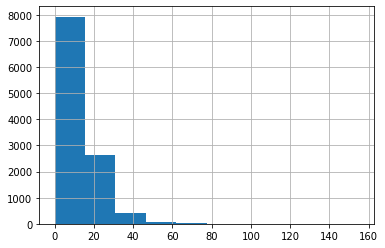

In [63]:
import matplotlib.pyplot as plt
seq_len = [len(i.split()) for i in train_data_sentences_processed]
pd.Series(seq_len).hist(bins=10)
plt.show()

# Data

In [65]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
# Xây dựng từ điển
vocab_size = 10000
embedding_dim = 32
max_length = 20

In [196]:
documents = train_data_sentences_processed + test_data_sentences_processed+valid_data_sentences_processed

In [197]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(documents)

In [198]:
train_data_sequences =  tokenizer.texts_to_sequences(train_data_sentences_processed)
test_data_sequences =  tokenizer.texts_to_sequences(test_data_sentences_processed)
valid_data_sequences =  tokenizer.texts_to_sequences(valid_data_sentences_processed)

In [200]:
padded_train_data_sequences = pad_sequences(train_data_sequences, maxlen=max_length, truncating='post', padding='post')
padded_test_data_sequences = pad_sequences(test_data_sequences, maxlen=max_length, truncating='post', padding='post')
padded_valid_data_sequences = pad_sequences(valid_data_sequences, maxlen=max_length, truncating='post', padding='post')


In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def print_cfn(model, X_test, y_test ):
  test_pred_probs = model.predict(X_test)
  test_preds = tf.argmax(test_pred_probs, axis=1)
  test_labels = tf.argmax(y_test, axis = 1)
  cfn_matrix = confusion_matrix(test_labels, test_preds)
  print(classification_report (test_labels, test_preds, digits=4))
  print(cfn_matrix)
  return cfn_matrix

## SVM

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC


In [89]:
# Create a pipeline
SVM_model = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", LinearSVC())
])

In [90]:
SVM_model.fit(X = train_data_sentences_processed,
              y = train_data_lablels_processed, )

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', LinearSVC())])

In [91]:
SVM_model.score(X=valid_data_sentences_processed,y=valid_data_lablels_processed)

0.5138483965014577

In [95]:
# Make predictions
SVM_preds = SVM_model.predict(test_data_sentences_processed)
SVM_preds

array(['Enjoyment', 'Enjoyment', 'Disgust', ..., 'Other', 'Sadness',
       'Disgust'], dtype='<U9')

In [94]:
SVM_cfn_matrix = confusion_matrix(test_data_lablels_processed, SVM_preds)
print(classification_report (test_data_lablels_processed, SVM_preds,digits=4))
print(SVM_cfn_matrix)

              precision    recall  f1-score   support

       Anger     0.2836    0.2375    0.2585        80
     Disgust     0.4664    0.5265    0.4947       264
   Enjoyment     0.5654    0.6269    0.5946       386
        Fear     0.6250    0.5435    0.5814        92
       Other     0.4348    0.4651    0.4494       258
     Sadness     0.5492    0.4569    0.4988       232
    Surprise     0.5455    0.3243    0.4068        74

    accuracy                         0.5051      1386
   macro avg     0.4957    0.4544    0.4692      1386
weighted avg     0.5062    0.5051    0.5022      1386

[[ 19  30   8   7  10   6   0]
 [ 23 139  37   7  36  16   6]
 [  6  47 242   6  54  28   3]
 [  2  10  12  50  10   7   1]
 [ 10  41  51   4 120  24   8]
 [  6  20  60   6  32 106   2]
 [  1  11  18   0  14   6  24]]


# Random Forest

In [116]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import classification_report
%matplotlib inline

In [117]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data_sentences_processed)

TfidfVectorizer()

In [118]:
encoder = LabelEncoder()
encoder.fit(train_data_lablels_processed)

LabelEncoder()

In [124]:
X_train = tfidf.transform(train_data_sentences_processed).toarray()
y_train = encoder.fit_transform(train_data_lablels_processed)

X_valid = tfidf.transform(valid_data_sentences_processed).toarray()
y_valid = encoder.fit_transform(valid_data_lablels_processed)

X_test  = tfidf.transform(test_data_sentences_processed).toarray()
y_test = encoder.transform(test_data_lablels_processed)

In [125]:
X_train_valid = np.vstack([X_train, X_valid])
y_train_valid = np.concatenate([y_train, y_valid], axis=0)

In [246]:
from sklearn.ensemble import  RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=256)
RF_model.fit(X_train, y_train)
ypred = RF_model.predict(X_test)

In [247]:
ypred

array([2, 2, 4, ..., 4, 2, 2])

In [248]:
cfn_matrix = confusion_matrix(ypred, y_test)
print(classification_report (ypred, y_test, digits=4))
print(cfn_matrix)

              precision    recall  f1-score   support

           0     0.1250    0.4762    0.1980        21
           1     0.5341    0.4448    0.4854       317
           2     0.6736    0.4618    0.5479       563
           3     0.4348    0.6897    0.5333        58
           4     0.3798    0.4188    0.3984       234
           5     0.3922    0.5230    0.4483       174
           6     0.2162    0.8421    0.3441        19

    accuracy                         0.4733      1386
   macro avg     0.3937    0.5509    0.4222      1386
weighted avg     0.5322    0.4733    0.4872      1386

[[ 10   5   1   1   0   4   0]
 [ 44 141  40  15  45  24   8]
 [ 14  72 260  23  88  77  29]
 [  1   5   6  40   2   4   0]
 [  5  27  50   5  98  32  17]
 [  6  14  28   8  23  91   4]
 [  0   0   1   0   2   0  16]]


# Word2vec

In [203]:
import gensim

# Setting Up Word2Vec
w2v_Size = 128
w2v_Window = 7
w2v_Epoch = 32
w2v_Min_Count = 20

# Defining Word2Vec Model
w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_Size, window=w2v_Window, min_count=w2v_Min_Count, workers=8)

In [204]:
# Building Vocabulary
documents_w2v = [text.split() for text in documents] 
w2v_model.build_vocab(documents_w2v)
print("Vocabulary Size: ", len(w2v_model.wv.vocab.keys()) + 1)

Vocabulary Size:  1222


In [205]:
# Training Word2Vec Model
w2v_model.train(documents_w2v, total_examples=len(documents_w2v), epochs=w2v_Epoch)

(4518618, 5795264)

In [206]:
from keras.layers import Embedding

# Setting Up Embedding Layer
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_Size))

for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

embedding_layer = Embedding(vocab_size, w2v_Size, weights=[embedding_matrix], input_length=max_length, trainable=False)

(5725, 128)


## LSTM

In [207]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional, Input
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D,Flatten
from tensorflow.keras import layers

In [208]:
dropout_threshold = 0.2 

In [239]:
LSTM_W2V = Sequential()
LSTM_W2V.add(embedding_layer)
LSTM_W2V.add(Dropout(0.5))
LSTM_W2V.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
LSTM_W2V.add(Flatten())
LSTM_W2V.add(Dense(64, activation='relu'))
LSTM_W2V.add(Dense(7, activation='softmax'))

In [240]:
LSTM_W2V.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 128)           732800    
                                                                 
 dropout_7 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 flatten_10 (Flatten)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 7)                 455       
                                                                 
Total params: 873,095
Trainable params: 140,295
Non-t

In [241]:
from keras.utils.vis_utils import plot_model

In [242]:
LSTM_W2V.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

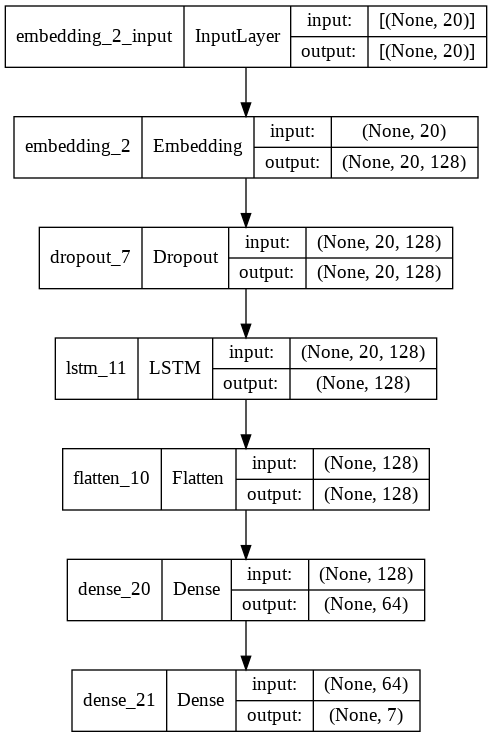

In [243]:
plot_model(LSTM_W2V,show_shapes=True, show_layer_names=True)

In [244]:
LSTM_W2V.fit(padded_train_data_sequences, train_data_lablels_tf,batch_size=32 ,
           epochs=20, validation_data=(padded_valid_data_sequences, valid_data_lablels_tf))

Epoch 1/20
347/347 [==============================] - 22s 58ms/step - loss: 1.6827 - acc: 0.3307 - val_loss: 1.5365 - val_acc: 0.3943
Epoch 2/20
347/347 [==============================] - 19s 55ms/step - loss: 1.5660 - acc: 0.3786 - val_loss: 1.5084 - val_acc: 0.3892
Epoch 3/20
347/347 [==============================] - 19s 55ms/step - loss: 1.5164 - acc: 0.4001 - val_loss: 1.5006 - val_acc: 0.4220
Epoch 4/20
347/347 [==============================] - 19s 55ms/step - loss: 1.4828 - acc: 0.4219 - val_loss: 1.4434 - val_acc: 0.4169
Epoch 5/20
347/347 [==============================] - 19s 56ms/step - loss: 1.4548 - acc: 0.4323 - val_loss: 1.4170 - val_acc: 0.4497
Epoch 6/20
347/347 [==============================] - 20s 57ms/step - loss: 1.4241 - acc: 0.4455 - val_loss: 1.4261 - val_acc: 0.4563
Epoch 7/20
347/347 [==============================] - 20s 57ms/step - loss: 1.3981 - acc: 0.4582 - val_loss: 1.4102 - val_acc: 0.4563
Epoch 8/20
347/347 [==============================] - 20s 57ms

In [245]:
LSTM_W2V_cfn=print_cfn(LSTM_W2V, padded_test_data_sequences, test_data_lablels_tf)

              precision    recall  f1-score   support

           0     0.5844    0.6192    0.6013       386
           1     0.5208    0.5948    0.5553       232
           2     0.5647    0.5217    0.5424        92
           3     0.3544    0.3500    0.3522        80
           4     0.5109    0.4432    0.4746       264
           5     0.6000    0.3243    0.4211        74
           6     0.4301    0.4651    0.4469       258

    accuracy                         0.5152      1386
   macro avg     0.5093    0.4741    0.4848      1386
weighted avg     0.5173    0.5152    0.5128      1386

[[239  39  10   5  30   2  61]
 [ 40 138   7   8  18   2  19]
 [  9  12  48   5  12   0   6]
 [  7   7   6  28  15   0  17]
 [ 45  24   9  25 117   4  40]
 [ 18   6   1   1   8  24  16]
 [ 51  39   4   7  29   8 120]]


## CNN

In [249]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, LayerNormalization,MaxPooling1D,GRU
from tensorflow.keras.layers import Dropout, Embedding
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

In [265]:
initializer = tf.keras.initializers.GlorotNormal()

input_layer = Input(shape=(max_length))
feature = embedding_layer(input_layer)

cnn_feature1  = Conv1D(128, kernel_size=5, padding='same', activation = 'relu')(feature)
cnn_feature1 = MaxPooling1D()(cnn_feature1)
cnn_feature1 = Dropout(dropout_threshold)(cnn_feature1)
cnn_feature2  = Conv1D(128, kernel_size=4, padding='same', activation = 'relu')(feature)
cnn_feature2 = MaxPooling1D()(cnn_feature2)
cnn_feature2 = Dropout(dropout_threshold)(cnn_feature2)
cnn_feature3  = Conv1D(128, kernel_size=3, padding='same', activation = 'relu')(feature)
cnn_feature3 = MaxPooling1D()(cnn_feature3)
cnn_feature3 = Dropout(dropout_threshold)(cnn_feature3)

combine_feature = tf.keras.layers.Concatenate()([cnn_feature1, cnn_feature2, cnn_feature3])
combine_feature = GlobalMaxPooling1D()(combine_feature)
combine_feature = LayerNormalization()(combine_feature)

classifier = Dense(96, activation='relu')(combine_feature)
classifier = Dropout(dropout_threshold)(classifier)
classifier = Dense(48, activation='relu')(classifier)
classifier = Dropout(dropout_threshold)(classifier)
classifier = Dense(32, activation='relu')(classifier)
classifier = Dropout(dropout_threshold)(classifier)
classifier = Dense(7, activation='softmax')(classifier)

CNN_model = Model(inputs= input_layer, outputs= classifier)

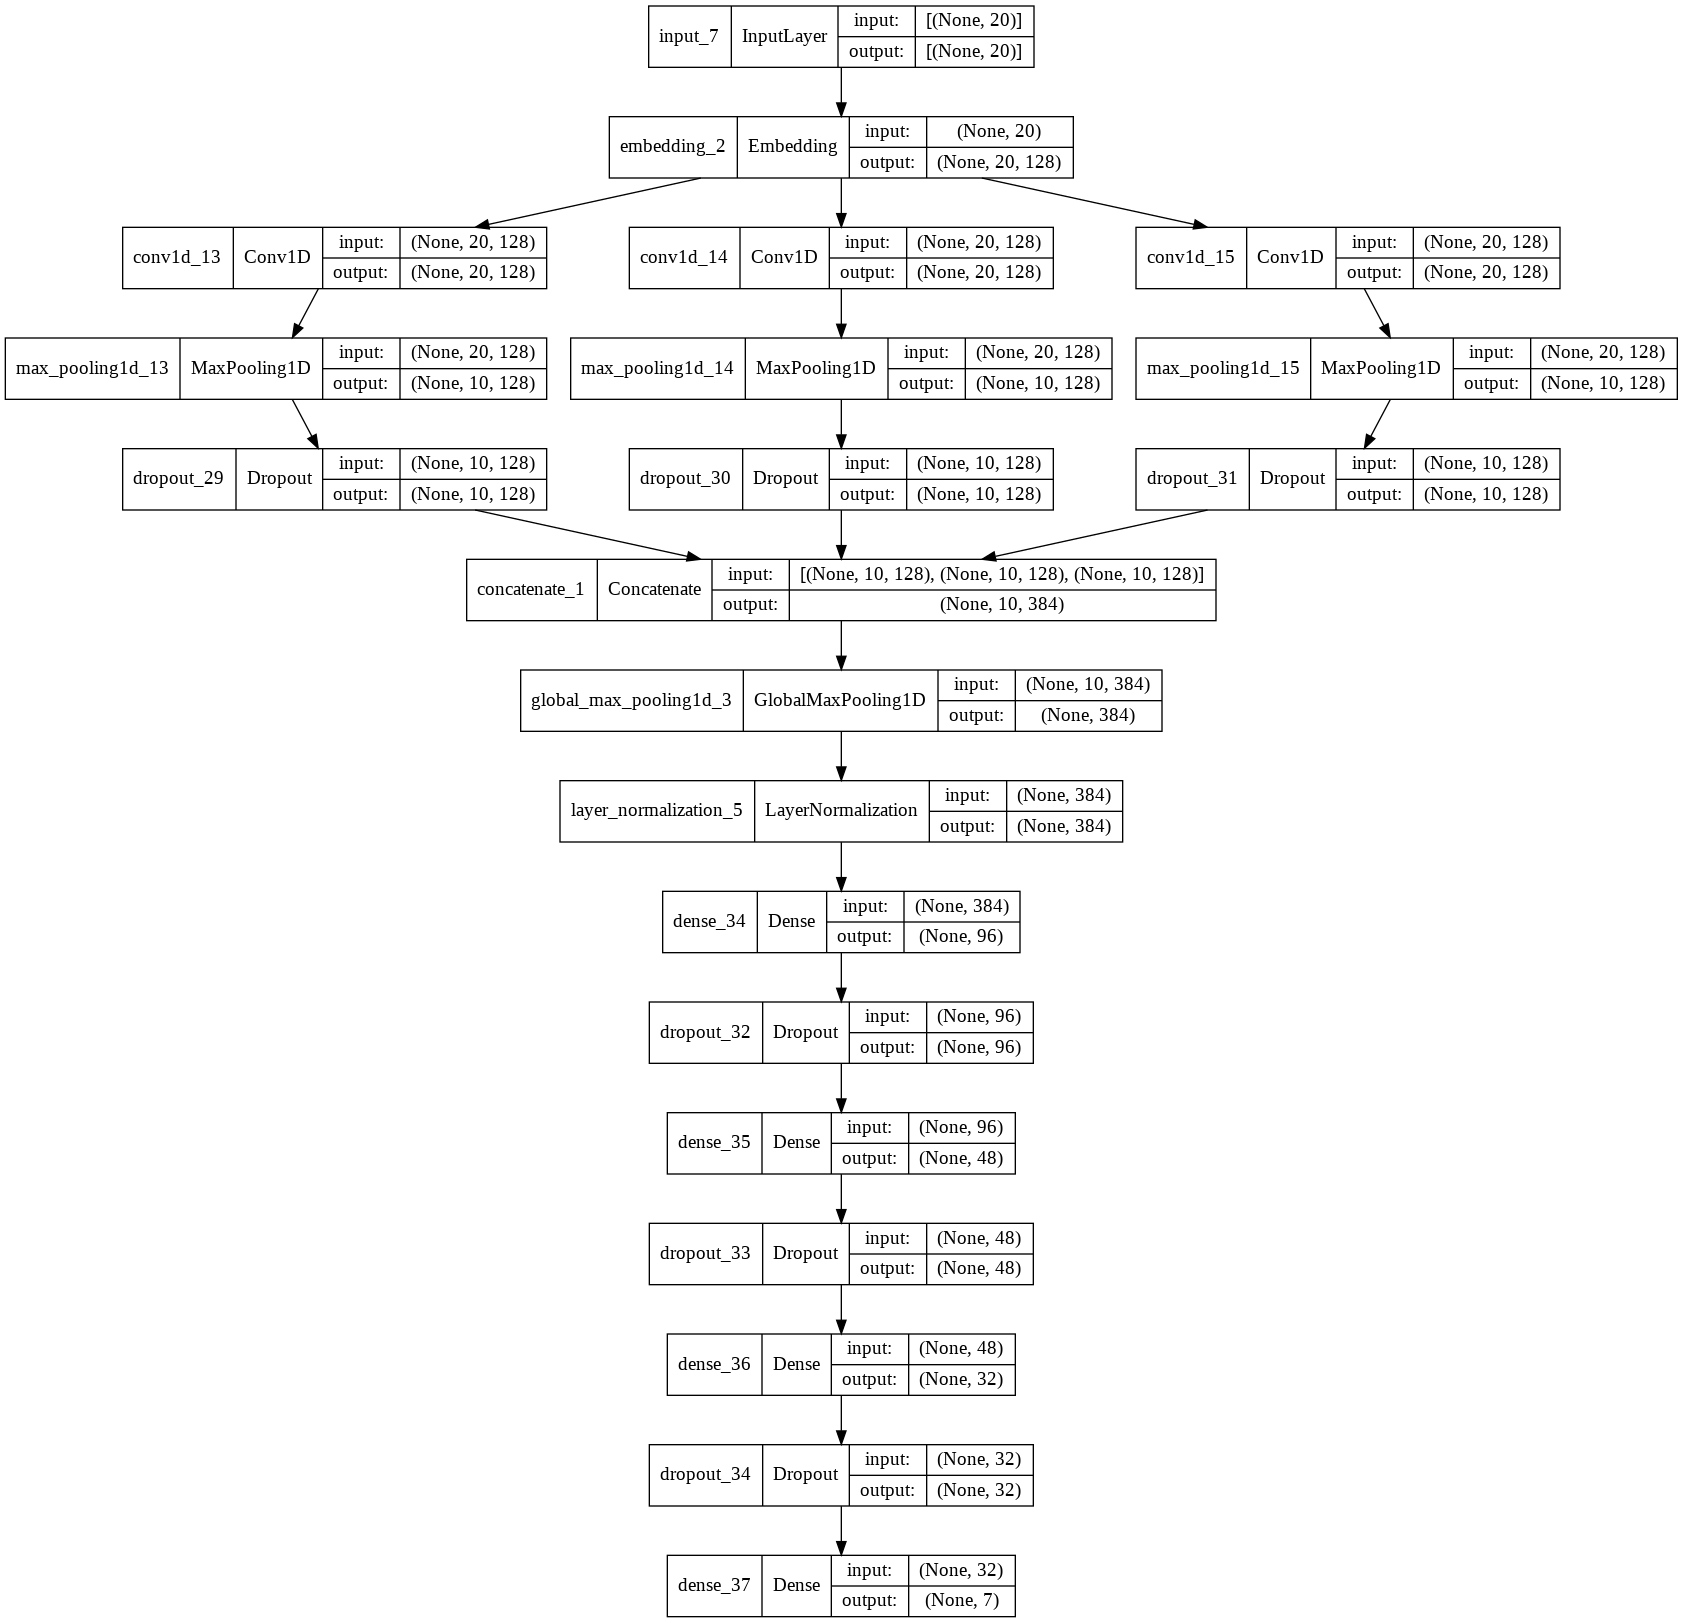

In [266]:
plot_model(CNN_model,show_shapes=True, show_layer_names=True)

In [267]:
CNN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
CNN_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 20, 128)      732800      ['input_7[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 20, 128)      82048       ['embedding_2[11][0]']           
                                                                                                  
 conv1d_14 (Conv1D)             (None, 20, 128)      65664       ['embedding_2[11][0]']           
                                                                                            

In [268]:
CNN_model.fit(padded_train_data_sequences, train_data_lablels_tf,batch_size=32 ,
           epochs=10, validation_data=(padded_valid_data_sequences, valid_data_lablels_tf))

Epoch 1/10
347/347 [==============================] - 9s 24ms/step - loss: 1.7636 - acc: 0.2980 - val_loss: 1.6207 - val_acc: 0.3878
Epoch 2/10
347/347 [==============================] - 8s 23ms/step - loss: 1.6004 - acc: 0.3627 - val_loss: 1.5023 - val_acc: 0.4191
Epoch 3/10
347/347 [==============================] - 8s 23ms/step - loss: 1.4927 - acc: 0.4157 - val_loss: 1.5107 - val_acc: 0.4111
Epoch 4/10
347/347 [==============================] - 8s 22ms/step - loss: 1.3854 - acc: 0.4603 - val_loss: 1.5006 - val_acc: 0.4023
Epoch 5/10
347/347 [==============================] - 8s 23ms/step - loss: 1.2936 - acc: 0.5013 - val_loss: 1.5075 - val_acc: 0.4191
Epoch 6/10
347/347 [==============================] - 8s 22ms/step - loss: 1.1950 - acc: 0.5389 - val_loss: 1.5470 - val_acc: 0.4286
Epoch 7/10
347/347 [==============================] - 8s 22ms/step - loss: 1.1154 - acc: 0.5818 - val_loss: 1.5552 - val_acc: 0.4402
Epoch 8/10
347/347 [==============================] - 8s 23ms/step - 

In [269]:
CNN_cfn=print_cfn(CNN_model, padded_test_data_sequences, test_data_lablels_tf)

              precision    recall  f1-score   support

           0     0.5187    0.6114    0.5612       386
           1     0.4751    0.3707    0.4165       232
           2     0.5692    0.4022    0.4713        92
           3     0.3000    0.2625    0.2800        80
           4     0.4578    0.3902    0.4213       264
           5     0.4651    0.2703    0.3419        74
           6     0.3401    0.4574    0.3901       258

    accuracy                         0.4481      1386
   macro avg     0.4466    0.3949    0.4118      1386
weighted avg     0.4544    0.4481    0.4446      1386

[[236  31   8   6  32   3  70]
 [ 46  86   3   5  25   5  62]
 [ 17  13  37   7   6   0  12]
 [  8   7   3  21  25   0  16]
 [ 49  20   8  26 103   7  51]
 [ 27   3   1   1   4  20  18]
 [ 72  21   5   4  30   8 118]]


# Visualization

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [271]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [272]:
svm_pred = SVM_model.predict(valid_data_sentences_processed)

In [273]:
svm_result = calculate_results(y_true=valid_data_lablels_processed, y_pred=svm_pred)
svm_result

{'accuracy': 51.38483965014578,
 'f1': 0.5098450324611996,
 'precision': 0.511225745073975,
 'recall': 0.5138483965014577}

In [278]:
RF_pred = RF_model.predict(X_valid)
RF_result = calculate_results(y_pred=RF_pred,y_true=y_valid)
RF_result

{'accuracy': 47.08454810495627,
 'f1': 0.4445313219345366,
 'precision': 0.45922994479895396,
 'recall': 0.4708454810495627}

In [284]:
lstm_pred = LSTM_W2V.predict(padded_valid_data_sequences)
lstm_pred = tf.argmax(lstm_pred, axis =1)

In [289]:
valid_data_lablels_idx = [label_dict[i] for i in valid_data_lablels_processed]

In [290]:
lstm_pred = LSTM_W2V.predict(padded_valid_data_sequences)
lstm_pred = tf.argmax(lstm_pred, axis =1)
lstm_result = calculate_results(y_pred=lstm_pred,y_true=valid_data_lablels_idx)
lstm_result

{'accuracy': 47.23032069970846,
 'f1': 0.4720928985117235,
 'precision': 0.4788380497783145,
 'recall': 0.47230320699708456}

In [291]:
CNN_pred = CNN_model.predict(padded_valid_data_sequences)
CNN_pred = tf.argmax(CNN_pred, axis =1)
CNN_result = calculate_results(y_pred=CNN_pred,y_true=valid_data_lablels_idx)
CNN_result

{'accuracy': 42.27405247813411,
 'f1': 0.42044060926605564,
 'precision': 0.4251718336300634,
 'recall': 0.4227405247813411}

In [293]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"SVM": svm_result,
                                  "Random Forest": RF_result,
                                  "LSTM": lstm_result,
                                  "CNN": CNN_result})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
SVM,51.384840,0.511226,0.513848,0.509845
Random Forest,47.084548,0.459230,0.470845,0.444531
LSTM,47.230321,0.478838,0.472303,0.472093
CNN,42.274052,0.425172,0.422741,0.420441


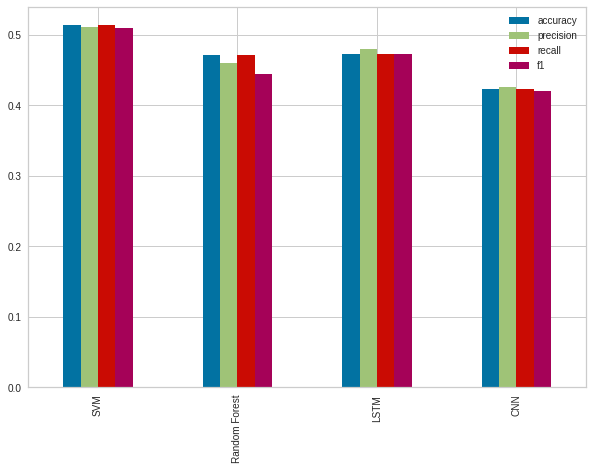

In [294]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

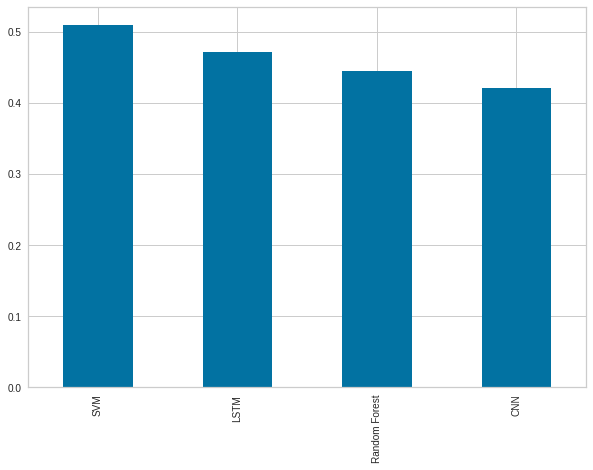

In [295]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));